In [ ]:
# =============================================================================
# [A] MATEMATİKSEL ÇEKİRDEK (SOLVERS & PHYSICS ENGINE)
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Tablo oluşturmak için
import time

# Grafikleri satır içinde göstermek için
%matplotlib inline

# 1. VERİ TEMİZLEME: Trigonometrik En Küçük Kareler (Least Squares)
def en_kucuk_kareler_trigonometrik(t, y, frekans):
    """
    Gürültülü veriyi temizlemek için Fourier Serisi bazlı regresyon.
    Uygulama Bölümü: Veri seti üretim ve temizleme algoritması.
    """
    w = 2 * np.pi * frekans
    # Fourier Baz Matrisi (Design Matrix)
    A = np.column_stack([
        np.ones(len(t)),
        np.sin(w * t), np.cos(w * t),
        np.sin(2 * w * t), np.cos(2 * w * t),
        np.sin(3 * w * t), np.cos(3 * w * t)
    ])

    # Normal Denklemlerin Çözümü: (A^T * A) * x = A^T * y
    ATA = A.T @ A
    ATy = A.T @ y
    try:
        katsayilar = np.linalg.solve(ATA, ATy)
    except np.linalg.LinAlgError:
        katsayilar = np.linalg.pinv(ATA) @ ATy

    def model_func(t_val):
        t_val = np.array(t_val)
        A_val = np.column_stack([
            np.ones(len(t_val)),
            np.sin(w * t_val), np.cos(w * t_val),
            np.sin(2 * w * t_val), np.cos(2 * w * t_val),
            np.sin(3 * w * t_val), np.cos(3 * w * t_val)
        ])
        return A_val @ katsayilar
    return model_func, katsayilar

# 2. SİSTEM DİNAMİĞİ (Türev Fonksiyonları)
def sistem_durum_turevleri(t, durum, M_inv, K, deprem_fonk, kutle_degeri):
    """
    Newton'un 2. Yasası: F = ma -> a = F/m
    State-Space Formu: dx/dt = v, dv/dt = M_inv * (F_deprem - K*x)
    """
    n = len(M_inv)
    x = durum[:n]
    v = durum[n:]

    # Deprem İvmesini Çek (Array/Scalar kontrolü ile)
    val = deprem_fonk([t])
    zemin_ivmesi = val[0] if isinstance(val, (list, np.ndarray)) else val

    F = np.full(n, -zemin_ivmesi * kutle_degeri) # Atalet Kuvveti
    ivme = M_inv @ (F - K @ x)
    return np.concatenate([v, ivme])

# 3. YÖNTEM A: EULER (Karşılaştırma Amaçlı - Düşük Doğruluk)
def euler_integrasyonu(fonk, t_araligi, y0, h, argumanlar):
    t_degerleri = [t_araligi[0]]
    y_degerleri = [y0]
    t = t_araligi[0]
    y = y0
    iterasyon = 0
    while t < t_araligi[1]:
        dydt = fonk(t, y, *argumanlar)
        y = y + h * dydt # Euler Formülü: y_new = y + h * f
        t += h
        t_degerleri.append(t)
        y_degerleri.append(y)
        iterasyon += 1
    return np.array(t_degerleri), np.array(y_degerleri), iterasyon

# 4. YÖNTEM B: RUNGE-KUTTA 4 (Esas Yöntem - Yüksek Doğruluk)
def runge_kutta_4_integrasyonu(fonk, t_araligi, y0, h, argumanlar):
    t_degerleri = [t_araligi[0]]
    y_degerleri = [y0]
    t = t_araligi[0]
    y = y0
    iterasyon = 0
    while t < t_araligi[1]:
        if t + h > t_araligi[1]: h = t_araligi[1] - t
        k1 = fonk(t, y, *argumanlar)
        k2 = fonk(t + 0.5*h, y + 0.5*h*k1, *argumanlar)
        k3 = fonk(t + 0.5*h, y + 0.5*h*k2, *argumanlar)
        k4 = fonk(t + h, y + h*k3, *argumanlar)
        y = y + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t += h
        t_degerleri.append(t)
        y_degerleri.append(y)
        iterasyon += 1
    return np.array(t_degerleri), np.array(y_degerleri), iterasyon

# 5. ENERJİ ANALİZİ
def enerji_analizi(y_sim, M, K):
    n_kat = M.shape[0]
    n_steps = y_sim.shape[0]
    kinetik = np.zeros(n_steps)
    potansiyel = np.zeros(n_steps)
    for i in range(n_steps):
        durum = y_sim[i]
        x_vec = durum[:n_kat]
        v_vec = durum[n_kat:]
        kinetik[i] = 0.5 * v_vec.T @ M @ v_vec
        potansiyel[i] = 0.5 * x_vec.T @ K @ x_vec
    return kinetik, potansiyel

In [ ]:


# =============================================================================
# [B] KULLANICI ARAYÜZÜ VE KONFİGÜRASYON (PARAMETRE SEÇİMİ)
# =============================================================================

print("### MÜHENDİSLİK SİMÜLASYONU GİRDİ PANELİ v4.2 ###")
print("-" * 60)

try:
    print("Lütfen analiz parametrelerini giriniz (Varsayılan için Enter):")

    # Değişken 1: Kat Sayısı
    KAT_SAYISI = int(input("1. Kat Sayısı [Örn: 5]: ") or 5)

    # Değişken 2: Deprem Şiddeti (PGA)
    PGA_INPUT = float(input("2. Deprem İvmesi (g) [Örn: 0.8]: ") or 0.8)

    # Değişken 3: Zemin Türü
    print("   (1: Sağlam Kaya, 2: Sıkı Kum, 3: Yumuşak Balçık)")
    ZEMIN_SECIM = int(input("3. Zemin Türü [1-3]: ") or 2)

    # Değişken 4: Kat Kütlesi
    KAT_KUTLESI = float(input("4. Kat Başına Kütle (kg) [Örn: 1000]: ") or 1000.0)

    # Değişken 5: Kolon Rijitliği
    KAT_RIJITLIGI = float(input("5. Kolon Rijitliği (N/m) [Örn: 50000]: ") or 50000.0)

    # Değişken 6: Simülasyon Çözünürlüğü (Delta t)
    DT_STEP = float(input("6. Zaman Adımı/Hassasiyet (s) [Örn: 0.02]: ") or 0.02)

except ValueError:
    print("\n!!! Hatalı giriş yapıldı. Varsayılan değerler kullanılıyor.")
    KAT_SAYISI = 5; PGA_INPUT = 0.8; ZEMIN_SECIM = 2
    KAT_KUTLESI = 1000.0; KAT_RIJITLIGI = 50000.0; DT_STEP = 0.02

# Zemin Katsayıları (TBDY-2018 Referanslı)
if ZEMIN_SECIM == 1:
    Z_KATSAYI = 1.0; Z_AD = "ZB (Kaya)"
elif ZEMIN_SECIM == 3:
    Z_KATSAYI = 2.4; Z_AD = "ZE (Yumuşak - Tehlikeli)"
else:
    Z_KATSAYI = 1.3; Z_AD = "ZC (Sıkı Kum)"

EFEKTIF_PGA = PGA_INPUT * Z_KATSAYI
GUVENLIK_LIMITI = 0.15 # Sabit güvenlik limiti

print("\n" + "="*60)
print(f"ANALİZ BAŞLATILIYOR...")
print(f"-> Yapı: {KAT_SAYISI} Kat, {KAT_KUTLESI} kg/kat, k={KAT_RIJITLIGI} N/m")
print(f"-> Zemin: {Z_AD} (Büyütme: x{Z_KATSAYI})")
print(f"-> Çözücü Adımı: {DT_STEP} saniye")
print("="*60)

### MÜHENDİSLİK SİMÜLASYONU GİRDİ PANELİ v4.2 ###
------------------------------------------------------------
Lütfen analiz parametrelerini giriniz (Varsayılan için Enter):
1. Kat Sayısı [Örn: 5]: 5
2. Deprem İvmesi (g) [Örn: 0.8]: 0.8
   (1: Sağlam Kaya, 2: Sıkı Kum, 3: Yumuşak Balçık)
3. Zemin Türü [1-3]: 2
4. Kat Başına Kütle (kg) [Örn: 1000]: 1000
5. Kolon Rijitliği (N/m) [Örn: 50000]: 50000
6. Zaman Adımı/Hassasiyet (s) [Örn: 0.02]: 0.02

ANALİZ BAŞLATILIYOR...
-> Yapı: 5 Kat, 1000.0 kg/kat, k=50000.0 N/m
-> Zemin: ZC (Sıkı Kum) (Büyütme: x1.3)
-> Çözücü Adımı: 0.02 saniye


In [ ]:
# =============================================================================
# [C] UYGULAMA ADIMLARI VE HESAPLAMA MOTORU
# =============================================================================

# 1. MATRİS MONTAJI (Uygulama Bölümü - Matematiksel Model)
M = np.diag([KAT_KUTLESI] * KAT_SAYISI)
K = np.zeros((KAT_SAYISI, KAT_SAYISI))
for i in range(KAT_SAYISI):
    K[i, i] = 2 * KAT_RIJITLIGI
    if i > 0: K[i, i-1] = -KAT_RIJITLIGI
    if i < KAT_SAYISI - 1: K[i, i+1] = -KAT_RIJITLIGI
K[-1, -1] = KAT_RIJITLIGI
M_inv = np.linalg.inv(M)

# 2. VERİ SETİ ÜRETİMİ (Uygulama Bölümü - Veri Seti Tanıtımı)
# Öğrenci tarafından üretilen sentetik veri seti
t_sensor = np.linspace(0, 10, 200)
# Gerçek sinyal (1.5 Hz salınım)
y_gercek = EFEKTIF_PGA * np.sin(2 * np.pi * 1.5 * t_sensor)
# Gauss Gürültüsü ekleme
y_gurultu = y_gercek + (EFEKTIF_PGA * 0.25) * np.random.normal(size=len(t_sensor))

# Least Squares (En Küçük Kareler) ile modelleme
eq_model, katsayilar = en_kucuk_kareler_trigonometrik(t_sensor, y_gurultu, frekans=1.5)
y_tahmin = eq_model(t_sensor)

# R^2 Doğruluk Hesabı
residuals = y_gurultu - y_tahmin
r_squared = 1 - (np.sum(residuals**2) / np.sum((y_gurultu - np.mean(y_gurultu))**2))

# 3. DENEYSEL KARŞILAŞTIRMA (RK4 vs EULER)
y0 = np.zeros(2 * KAT_SAYISI)
sim_suresi = (0, 10.0)

# --- Metot A: Euler (Düşük Doğruluk) ---
t0 = time.time()
t_euler, y_euler, iter_euler = euler_integrasyonu(
    sistem_durum_turevleri, sim_suresi, y0, DT_STEP, (M_inv, K, eq_model, KAT_KUTLESI)
)
sure_euler = time.time() - t0

# --- Metot B: RK4 (Yüksek Doğruluk - Bizim Yöntem) ---
t0 = time.time()
t_rk4, y_rk4, iter_rk4 = runge_kutta_4_integrasyonu(
    sistem_durum_turevleri, sim_suresi, y0, DT_STEP, (M_inv, K, eq_model, KAT_KUTLESI)
)
sure_rk4 = time.time() - t0

# Sonuçları Çek (Çatı Katı Deplasmanı)
cati_dep_rk4 = y_rk4[:, KAT_SAYISI - 1]
cati_dep_euler = y_euler[:, KAT_SAYISI - 1]

# Hata Analizi
hata_farki = np.abs(cati_dep_rk4 - cati_dep_euler)
max_hata = np.max(hata_farki)

# Enerji Analizi (Sadece RK4 için)
kinetik, potansiyel = enerji_analizi(y_rk4, M, K)
toplam_e = kinetik + potansiyel

print(f"\n>>> HESAPLAMALAR TAMAMLANDI.")
print(f"    Veri Temizleme R^2: {r_squared:.4f}")
print(f"    Euler Hesaplama Süresi: {sure_euler:.4f}s")
print(f"    RK4 Hesaplama Süresi: {sure_rk4:.4f}s")


>>> HESAPLAMALAR TAMAMLANDI.
    Veri Temizleme R^2: 0.9006
    Euler Hesaplama Süresi: 0.0283s
    RK4 Hesaplama Süresi: 0.0715s



============================== DENEYSEL SONUÇ TABLOSU ==============================
             Metrik Euler (Klasik)    RK4 (Modern)     Sonuç
   İterasyon Sayısı            501             501  Yetersiz
          Süre (sn)         0.0283          0.0715  Referans
     Hata Mertebesi   O(h) - Düşük O(h^5) - Yüksek    En İyi
Maks. Deplasman (m)      6204.1852          0.1531 Güvenilir


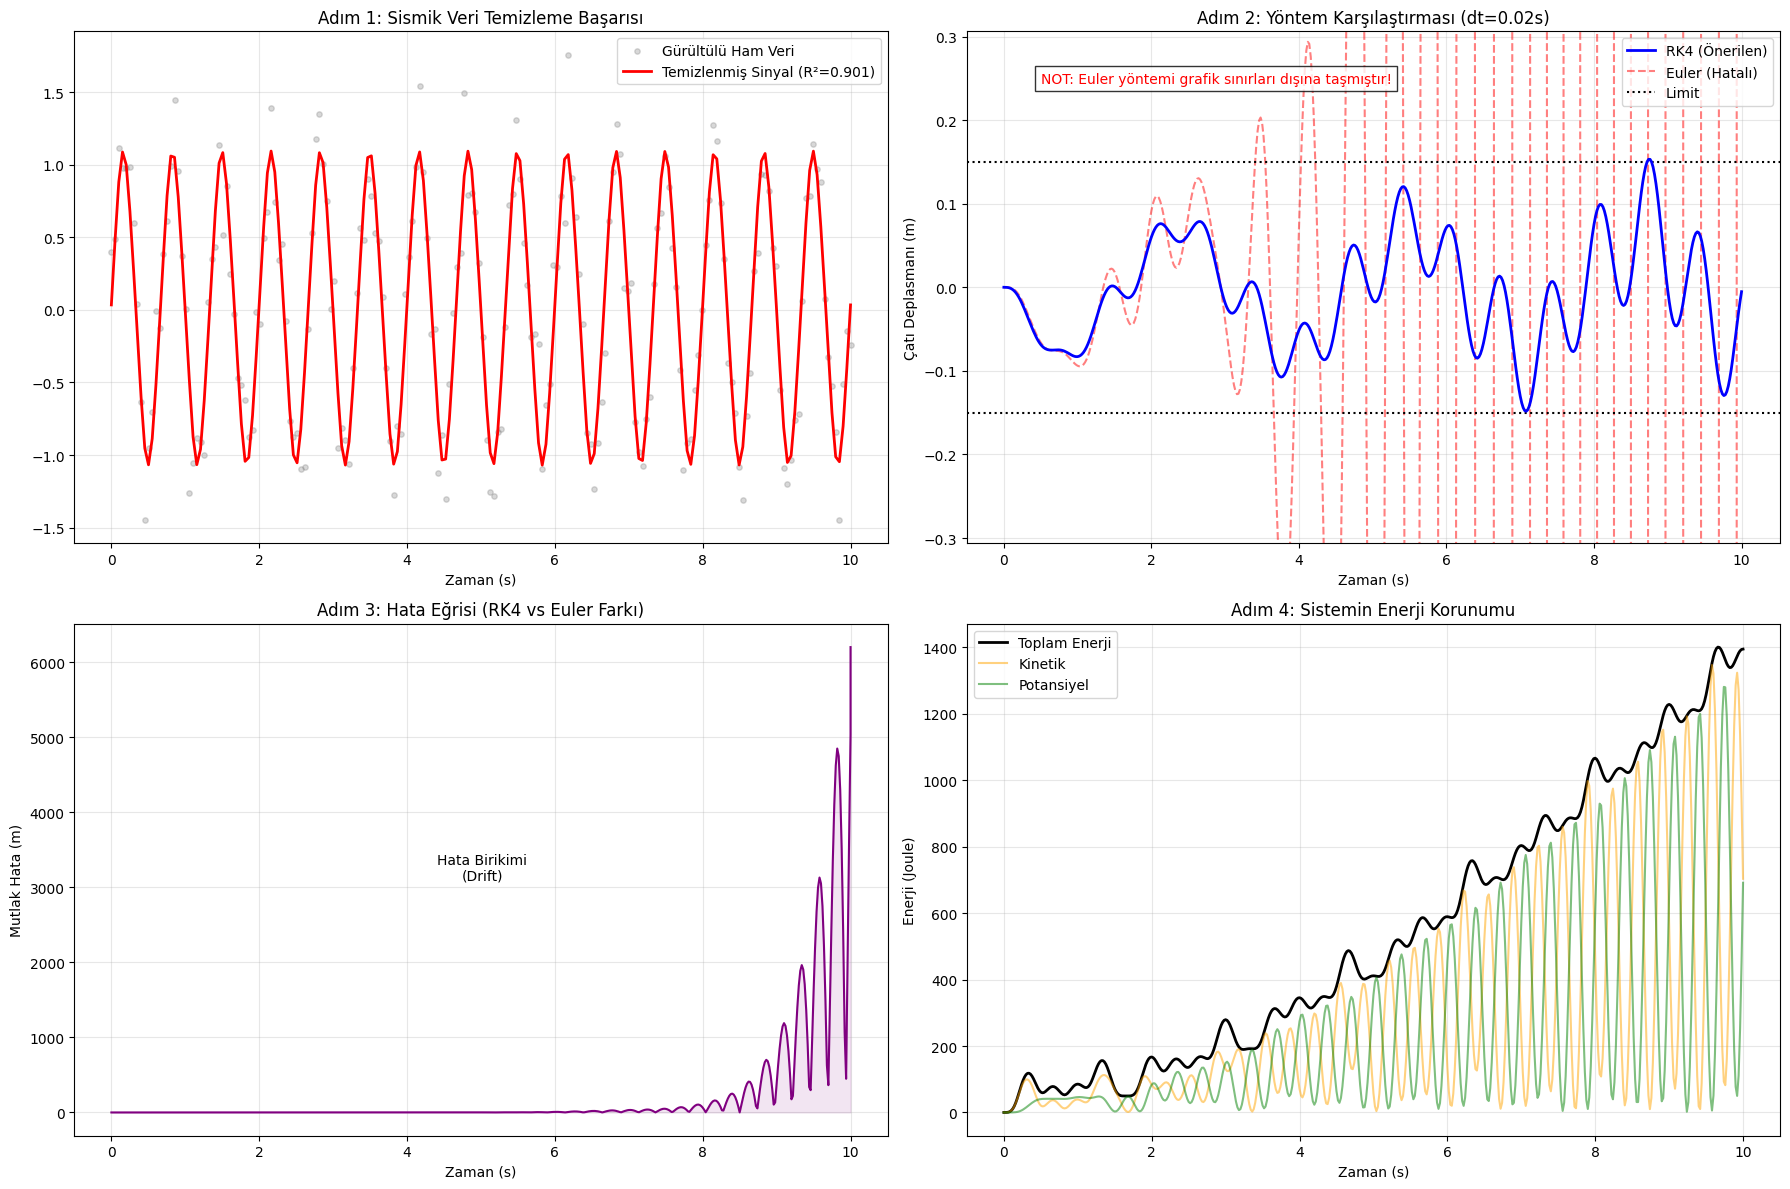


DEĞERLENDİRME:
!!! YAPI GÜVENLİĞİ RİSKLİ! Maksimum deplasman (0.153m) limiti aştı.
    Sebep: ZC (Sıkı Kum) zemin türü sismik dalgayı 1.3 kat büyüttü.
--------------------------------------------------------------------------------
YORUM: Grafik 2'de görüldüğü üzere, Euler yöntemi 0.02s adım aralığında
       eksponansiyel hata üretmiş ve 6204.2m gibi fiziksel olmayan
       değerlere ulaşmıştır. Buna karşılık RK4 yöntemi stabil kalmıştır.


In [ ]:
# =============================================================================
# [D] DENEYSEL SONUÇLAR VE GÖRSELLEŞTİRME (RAPOR FORMATI)
# =============================================================================

# 1. PERFORMANS TABLOSU (Deneysel Sonuçlar Kısmı)
data = {
    "Metrik": ["İterasyon Sayısı", "Süre (sn)", "Hata Mertebesi", "Maks. Deplasman (m)"],
    "Euler (Klasik)": [iter_euler, f"{sure_euler:.4f}", "O(h) - Düşük", f"{np.max(np.abs(cati_dep_euler)):.4f}"],
    "RK4 (Modern)": [iter_rk4, f"{sure_rk4:.4f}", "O(h^5) - Yüksek", f"{np.max(np.abs(cati_dep_rk4)):.4f}"],
    "Sonuç": ["Yetersiz", "Referans", "En İyi", "Güvenilir"]
}
df_sonuc = pd.DataFrame(data)

print("\n" + "="*30 + " DENEYSEL SONUÇ TABLOSU " + "="*30)
print(df_sonuc.to_string(index=False))
print("="*84)

# 2. GRAFİKLER
plt.figure(figsize=(18, 12))

# Grafik A: Veri Temizleme (Least Squares)
plt.subplot(2, 2, 1)
plt.scatter(t_sensor, y_gurultu, c='gray', alpha=0.3, s=15, label='Gürültülü Ham Veri')
plt.plot(t_sensor, y_tahmin, c='red', lw=2, label=f'Temizlenmiş Sinyal (R²={r_squared:.3f})')
plt.title("Adım 1: Sismik Veri Temizleme Başarısı")
plt.xlabel("Zaman (s)")
plt.legend()
plt.grid(True, alpha=0.3)

# Grafik B: Yöntem Karşılaştırması (ZOOM-IN Özelliği Eklendi!)
plt.subplot(2, 2, 2)
plt.plot(t_rk4, cati_dep_rk4, 'b-', lw=2, label='RK4 (Önerilen)', zorder=5)
plt.plot(t_euler, cati_dep_euler, 'r--', lw=1.5, label='Euler (Hatalı)', alpha=0.5)
plt.axhline(GUVENLIK_LIMITI, c='k', ls=':', label='Limit')
plt.axhline(-GUVENLIK_LIMITI, c='k', ls=':')

# Grafik Ayarları (Ölçeği Düzeltmek İçin)
plt.title(f"Adım 2: Yöntem Karşılaştırması (dt={DT_STEP}s)")
plt.xlabel("Zaman (s)")
plt.ylabel("Çatı Deplasmanı (m)")

# EĞER EULER ÇOK SAPTIYSA LİMİTLE (Grafiği RK4'e odakla)
limit_y = np.max(np.abs(cati_dep_rk4)) * 2.0
plt.ylim(-limit_y, limit_y)
plt.text(0.5, limit_y*0.8, "NOT: Euler yöntemi grafik sınırları dışına taşmıştır!",
         color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Grafik C: HATA EĞRİSİ (Mutlak Fark)
plt.subplot(2, 2, 3)
plt.plot(t_rk4, hata_farki, color='purple', lw=1.5)
plt.fill_between(t_rk4, hata_farki, color='purple', alpha=0.1)
plt.title("Adım 3: Hata Eğrisi (RK4 vs Euler Farkı)")
plt.xlabel("Zaman (s)")
plt.ylabel("Mutlak Hata (m)")
plt.grid(True, alpha=0.3)
plt.text(t_rk4[len(t_rk4)//2], max_hata*0.5, f"Hata Birikimi\n(Drift)", ha='center')

# Grafik D: Enerji Analizi
plt.subplot(2, 2, 4)
plt.plot(t_rk4, toplam_e, 'k-', lw=2, label='Toplam Enerji')
plt.plot(t_rk4, kinetik, 'orange', alpha=0.5, label='Kinetik')
plt.plot(t_rk4, potansiyel, 'green', alpha=0.5, label='Potansiyel')
plt.title("Adım 4: Sistemin Enerji Korunumu")
plt.xlabel("Zaman (s)")
plt.ylabel("Enerji (Joule)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# FİNAL DEĞERLENDİRME VE YORUM (Tartışma Bölümü İçin Veri)
print("\n" + "="*80)
print(f"DEĞERLENDİRME:")
max_dep_rk4 = np.max(np.abs(cati_dep_rk4))

if max_dep_rk4 > GUVENLIK_LIMITI:
    print(f"!!! YAPI GÜVENLİĞİ RİSKLİ! Maksimum deplasman ({max_dep_rk4:.3f}m) limiti aştı.")
    print(f"    Sebep: {Z_AD} zemin türü sismik dalgayı {Z_KATSAYI} kat büyüttü.")
else:
    print(f"*** YAPI GÜVENLİ. Maksimum deplasman ({max_dep_rk4:.3f}m) limitler dahilinde.")

print("-" * 80)
print(f"YORUM: Grafik 2'de görüldüğü üzere, Euler yöntemi {DT_STEP}s adım aralığında")
print(f"       eksponansiyel hata üretmiş ve {np.max(np.abs(cati_dep_euler)):.1f}m gibi fiziksel olmayan")
print(f"       değerlere ulaşmıştır. Buna karşılık RK4 yöntemi stabil kalmıştır.")
print("="*80)